In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
!pip install lightning
from lightning import LightningModule, LightningDataModule, Trainer, Callback
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import pickle
!pip install umap-learn
import umap.umap_ as umap
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
class LeNet(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        predicts = torch.argmax(logits, dim=1)
        accuracy = accuracy_score(y.cpu().numpy(), predicts.cpu().numpy())
        values = {"train_loss": loss, "train_accuracy": torch.tensor(accuracy)}
        self.log_dict(values, prog_bar=True)
        return loss

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        predicts = torch.argmax(logits, dim=1)
        accuracy = accuracy_score(y.cpu().numpy(), predicts.cpu().numpy()) * 100
        clear_output(wait=True)
        self.log("test_accuracy", accuracy, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return preds

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.007)


model = LeNet.load_from_checkpoint(
    "/content/drive/MyDrive/CNNs/Lightning/lightning_logs/version_0/checkpoints/epoch=12-step=6500.ckpt"
)
model.eval()

In [21]:
class MNIST(LightningDataModule):
    def __init__(self, batch_size=100):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

    def prepare_data(self):
        datasets.MNIST(root=".", train=False, download=True)

    def setup(self, stage=None):
        if stage in ("test", None):
            self.mnist_test = datasets.MNIST(
                root=".", train=False, transform=self.transform
            )

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)


data = MNIST()

In [22]:
def test(index, data, predictions):
    for i, (images, labels) in enumerate(data.test_dataloader()):
        if i == index:
            predict = predictions[i]

            plt.figure(figsize=(40, 40))
            for i in range(images.size(0)):
                plt.subplot(10, 10, i + 1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(images[i].squeeze(), cmap="gray")
                if predict[i] == labels[i]:
                    plt.title("{}".format(predict[i]), fontsize=27, color="green")
                else:
                    plt.title(
                        "{} (correct: {})".format(predict[i], labels[i]),
                        fontsize=27,
                        color="red",
                    )

            plt.show()

            break

In [35]:
trainer = Trainer(limit_train_batches=0, limit_val_batches=0)
trainer.fit(model)
trainer.test(datamodule=data, ckpt_path="last")
predictions = trainer.predict(model, dataloaders=data.test_dataloader())

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     98.9000015258789      │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

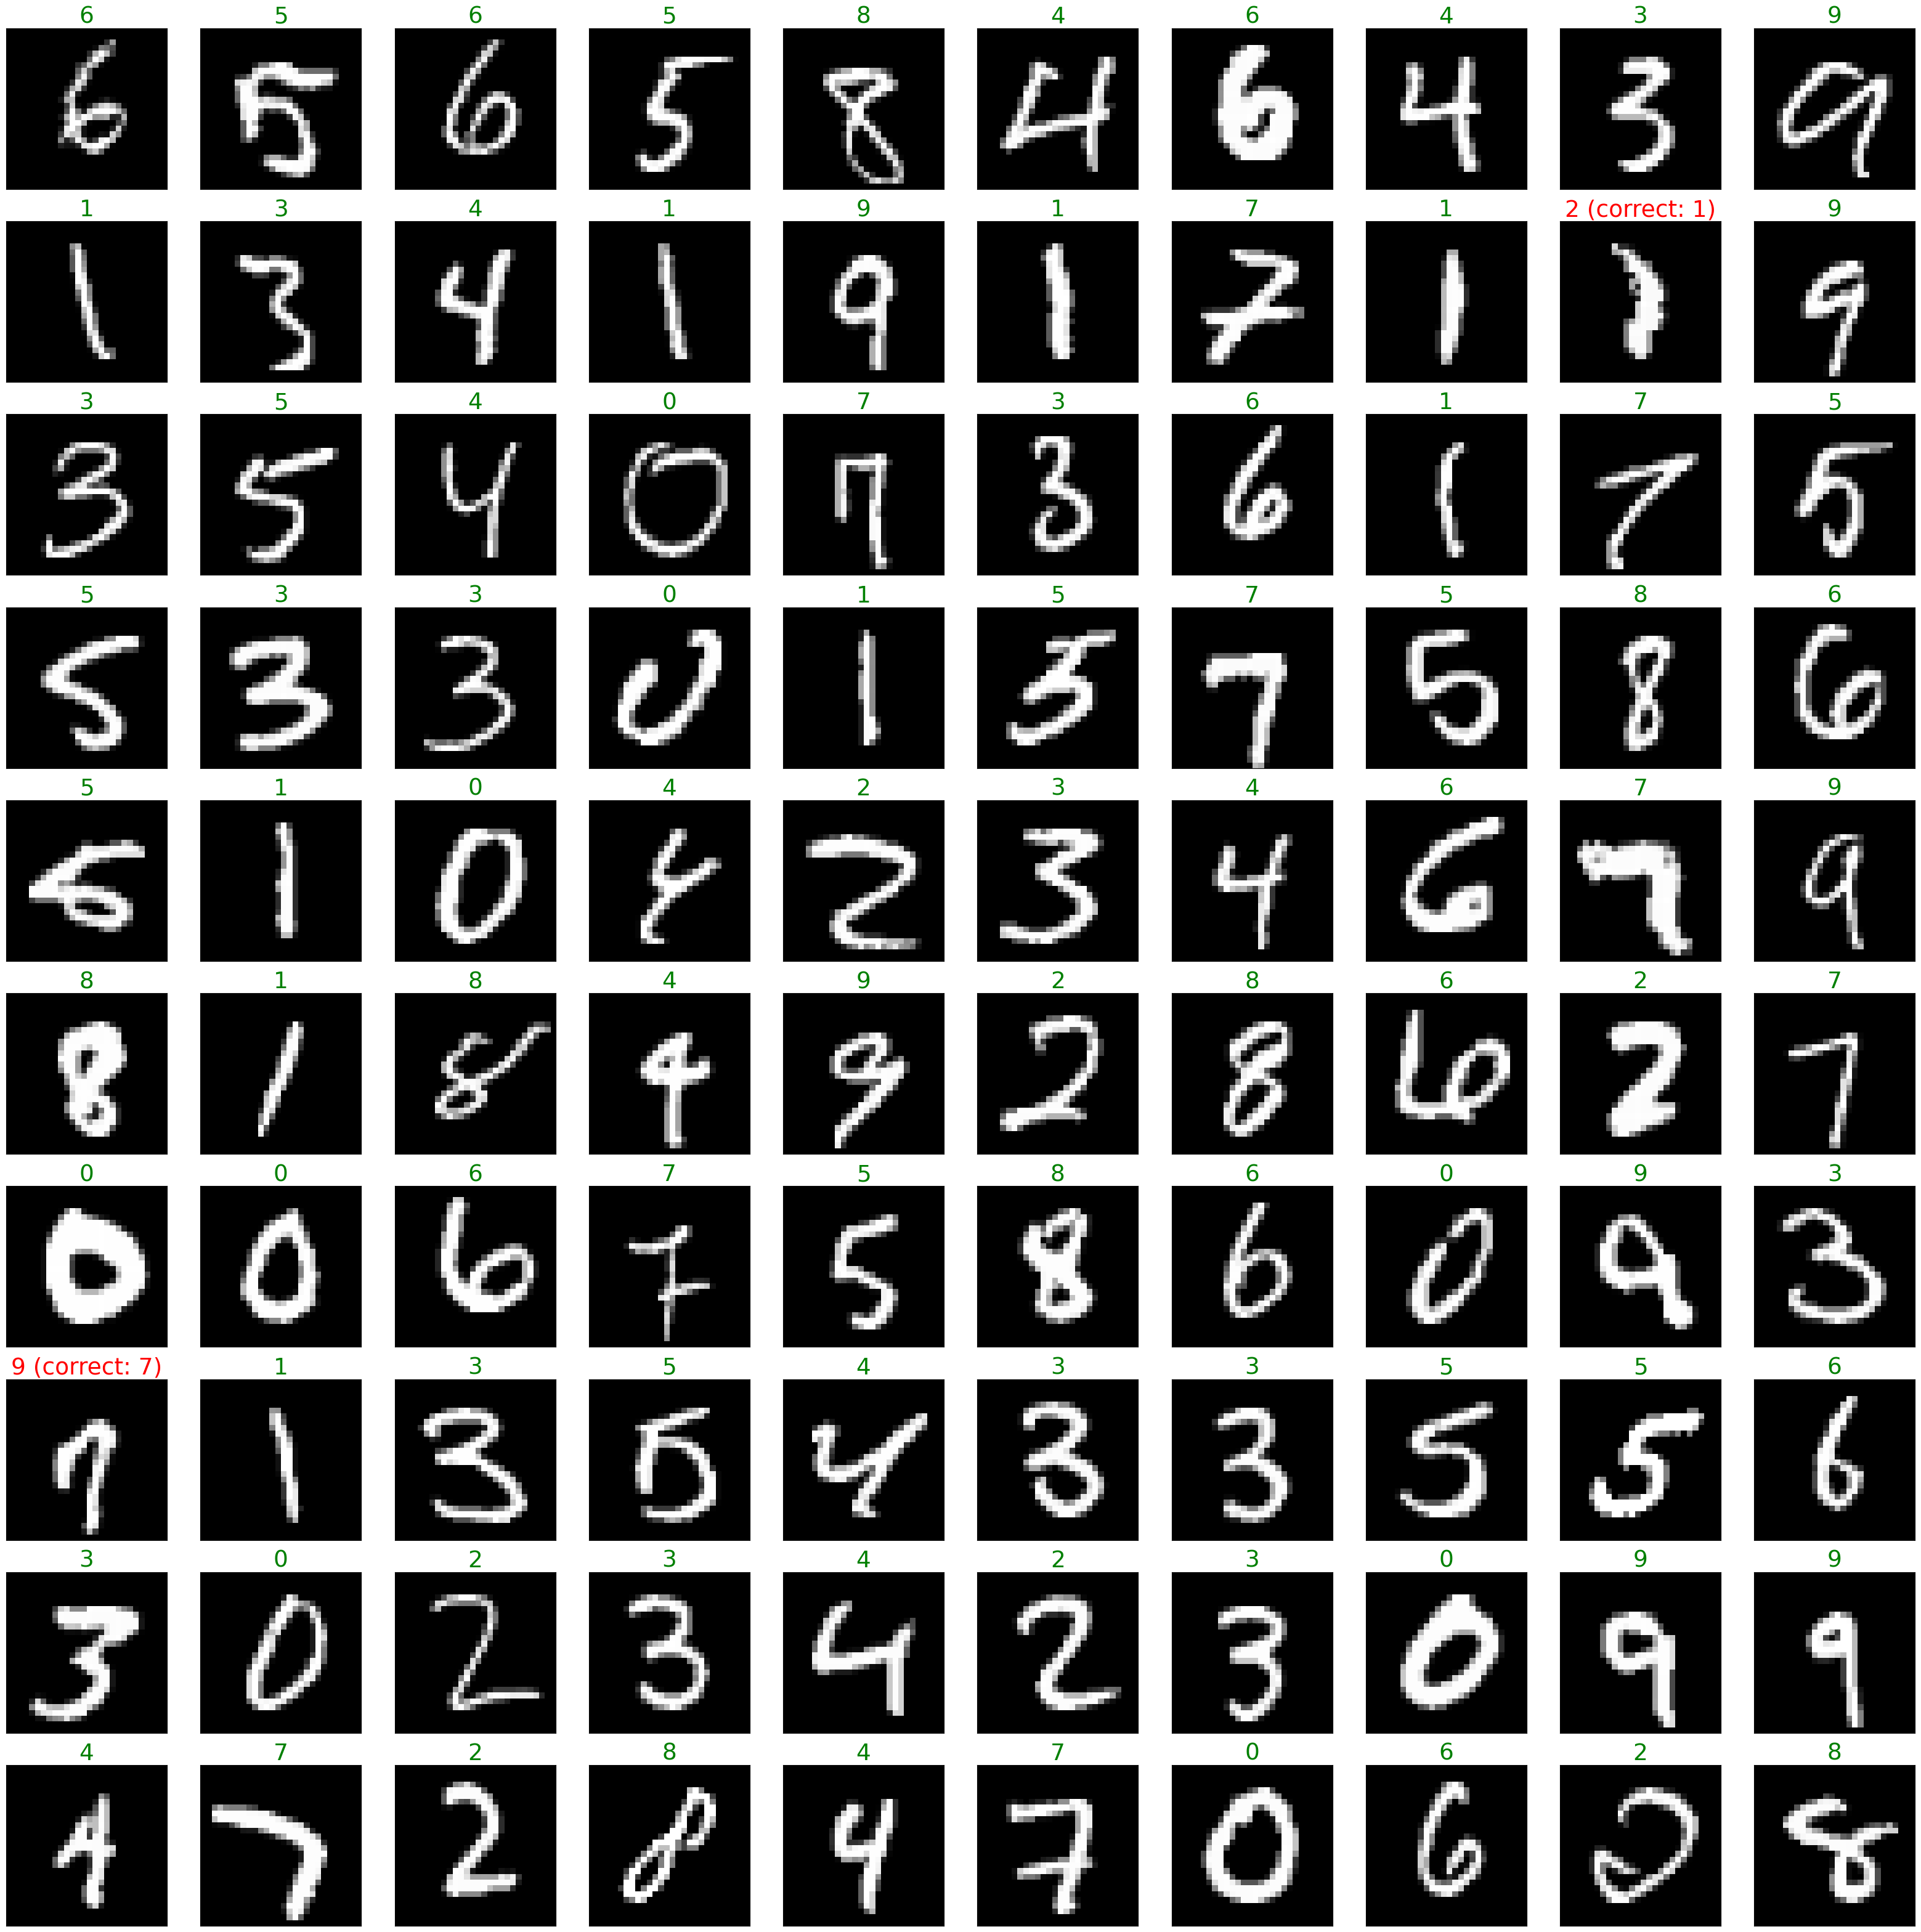

In [36]:
index = random.randint(0, (len(data.test_dataloader())) - 1)
test(index, data, predictions)

In [39]:
def save_embeddings(model, loader, filename):
    embeddings_data = []

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            embeddings = model(images)
            for i in range(len(images)):
                embedding = embeddings[i].numpy()
                img = images[i].numpy()
                label = labels[i].item()
                data_entry = {"image": img, "label": label, "embedding": embedding}
                embeddings_data.append(data_entry)

    with open(filename, "wb") as f:
        pickle.dump(embeddings_data, f)


def load_embeddings(filename):
    with open(filename, "rb") as f:
        embeddings_data = pickle.load(f)

    embeddings = [entry["embedding"] for entry in embeddings_data[:500]]
    labels = [entry["label"] for entry in embeddings_data[:500]]

    reducer = umap.UMAP()
    embeddings_2d = reducer.fit_transform(embeddings)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="tab10")
    plt.colorbar()
    plt.title("MNIST")
    plt.show()

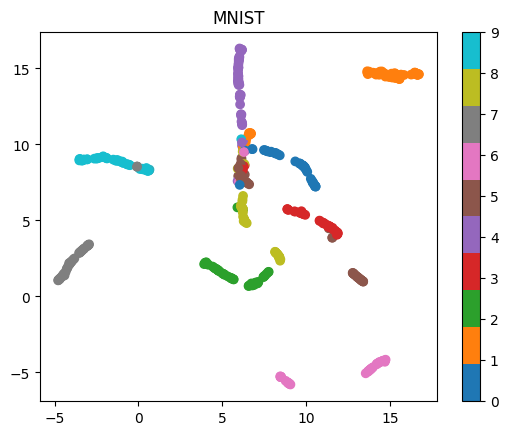

In [40]:
filename = "/content/drive/MyDrive/CNNs/Torch/embeddings.pickle"

loader = data.test_dataloader()
save_embeddings(model, loader, filename)
load_embeddings(filename)